In [2]:
import numpy as np
from numpy import linalg as LA
from scipy.linalg import fractional_matrix_power
import pickle
import math
import random
import pandas as pd
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def RobustGC(W , y, eta=1):
    row, col = np.diag_indices_from(W)
    D = np.zeros((len(row), len(col)))
    D[row, col] = W.sum(axis=1)
    T = fractional_matrix_power(D, -0.5)
    S = T @ W @ T
    I = np.identity(len(S))
    LN = I - S
    v0 = np.sqrt(np.diagonal(D))
    v0 = v0 / np.sqrt(np.sum(v0**2))
    temp0 = S - v0.dot(v0)
    e = LA.eigvals(temp0)
    e = (np.sort(e))
    a = LA.eigvals(LN)
    lambda1 = (np.sort(a)[1])
    # print(lambda1)
    # print(e[len(e)-1])
    # print(lambda1+e[len(e)-1])
    gamma = eta*lambda1
    temp =LA.inv(LN/gamma - np.identity(len(LN)))
    temp2 = y - v0.dot(v0.dot(y))
    f = temp@temp2
    yhat = np.sign(f)
    return yhat,f,gamma

def compute_dx(x,dataset,sigma):
    dx = 0
    gamma = 1 / np.power(sigma, 2)
    for i in range(len(dataset)):
        k = np.exp(-gamma * np.linalg.norm(np.array(x) - np.array(dataset[i])))
        dx +=k
    return dx

def out_of_sample(x,dataset,yhat,sigma,gamma,d_list):
       
    dx = compute_dx(x,dataset,sigma)
    temp1 = 1/(1-gamma-(1/dx))

    gamma = 1 / np.power(sigma, 2)
    S = 0
    for i in range(len(dataset)):
        k = np.exp(-gamma * np.linalg.norm(np.array(x) - np.array(dataset[i])))
        s = (k / np.sqrt(dx*d_list[i])) *yhat[i]
        S +=s
    return np.sign(temp1*S)

In [5]:
def sample_labels(label_list,percentage):
    y = np.zeros((len(label_list)), dtype=float)
    negative_indices = [i for i, x in enumerate(label_list) if x == -1]
    positive_indices = [i for i, x in enumerate(label_list) if x == 1]
    n = math.ceil(len(label_list)*(percentage/100))
    a = random.sample(negative_indices, 1)
    b = random.sample(positive_indices, 1)
    y[a] = -1
    y[b] = 1
    negative_indices.remove(a[0])
    positive_indices.remove(b[0])
    positive_indices.extend(negative_indices)
    if n-2 > 0 :
        indices = random.sample(positive_indices, n-2)
        for index in indices :
            if label_list[index] == -1:
                y[index] = -1
            else:
                y[index] = 1
    return y

def find_accuracy(yhat,y_true,y):
    n = sum(y == 0)
    counter =0
    for i,element in enumerate(y):
        if element ==0:
            if yhat[i] == y_true[i]:
                counter+=1
    return (counter/n) * 100

In [6]:
def make_dataset(data_path='./usps',new_file_path='out.txt',numberOfsamples=125):

    with open(data_path) as f:
        data = f.readlines()
    counter4 = 0
    counter9 = 0
    with open(new_file_path, "w") as f1:
        for i in range(len(data)):
            if data[i][0] == '4' and counter4 <numberOfsamples:
                f1.write(data[i])
                counter4+=1
                print(counter4)
            if data[i][0] == '9' and counter9 <numberOfsamples:
                f1.write(data[i])
                counter9+=1
                print(counter9)
    f.close()
    f1.close()

def read_data(filepath):

    with open(filepath) as f:
        data = f.readlines()

    vectors  = np.zeros((len(data), 256), dtype=float)

    for i in range(len(data)):
        d = data[i].split(':')
        v = []
        for j in range(1, len(d)):
            v.append(float(d[j].split(' ')[0]))
        vectors[i] = v

    return vectors


def generate_weight_mat(vectors,sigma):

    gamma = 1/np.power(sigma,2)
    weight_mat = np.zeros((len(vectors),len(vectors)),dtype=float)
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            weight_mat[i][j] = np.exp(-gamma * np.linalg.norm(np.array(vectors[i])-np.array(vectors[j])))

    return weight_mat

def generate_labels(filepath):
    labels = []
    c = 0
    d = 0
    with open(filepath) as file_in:

        for line in file_in:
            l = (line[0])
            if l == '4':
                c += 1
                labels.append(-1)
            if l == '9':
                labels.append(1)
                d += 1
    return labels

In [7]:
def calculate_accuracy(y,y_true):
    s = 0
    for i in range(len(y)):
        if y[i] == y_true[i]:
            s+=1
    return (s/len(y)) * 100

In [15]:
def test1():
    filePath = "/content/gdrive/MyDrive/usps_1000.txt"
    vectors = read_data(filePath)
    labels = generate_labels(filePath)
    df = pd.DataFrame(vectors, columns=[str(i) for i in range(256)])
    df.insert(256, 'label', labels)
    all_accuracy = []
    js = []
    for j in range(10, 991,40):
        js.append(j)
        accuracies = []
        for k in range(20):
            # new_df = df.groupby('label').apply(lambda x: x.sample(n=5)).reset_index(drop = True)
            new_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=5))
            remain_df = df.drop(new_df.index)
            sample2 = (remain_df.sample(n=j))
            final_sample = new_df.append(sample2)
            y_true = final_sample['label'].tolist()
            y = np.zeros(len(y_true))
            for i in range(10):
                y[i] = y_true[i]
            remain_df = remain_df.drop(sample2.index)

            final_sample.drop(['label'], axis=1, inplace=True)
            list_of_data = final_sample.to_numpy()
            # list_of_data, y = shuffle(list_of_data, y)
            mat = generate_weight_mat(list_of_data, 5)
            yhat,f, gamma = RobustGC(mat, y, 0.9)
            acc1 = find_accuracy(yhat, y_true, y)
            print(acc1, k)

            # out of sample
            y_true2 = remain_df['label'].tolist()
            remain_df.drop(['label'], axis=1, inplace=True)
            remain_list = remain_df.values.tolist()
            y2 = []
            # dump_d_list(list_of_data,5,j)

            d_list = []
            for i in range(len(list_of_data)):
              d_list.append(compute_dx(list_of_data[i],list_of_data,5))


            for i, vector in enumerate(remain_list):
                d = out_of_sample(vector, list_of_data, f, 5, gamma,d_list)
                print(d, i)
                y2.append(d)
            print(y2)
            acc2 = (calculate_accuracy(y2, y_true2))
            print("**************************************")
            print(acc2)
            accuracy = (j * acc1 + (990 - j) * acc2) / 990
            print(accuracy)
            accuracies.append(accuracy)
            print(k)
            print("*****************************************")
        acc3 =sum(accuracies)/20
        all_accuracy.append(acc3)
        with open("/content/gdrive/MyDrive/accuracy.txt","a") as f:
          f.write(str(acc3)+"\n")

    print("#####################")
    print(all_accuracy)
    return all_accuracy,js

In [17]:
all_accuracy,js = test1()

Streaming output truncated to the last 5000 lines.
1.0 50
1.0 51
1.0 52
-1.0 53
-1.0 54
1.0 55
1.0 56
1.0 57
1.0 58
1.0 59
-1.0 60
-1.0 61
1.0 62
1.0 63
1.0 64
-1.0 65
-1.0 66
-1.0 67
1.0 68
1.0 69
1.0 70
1.0 71
1.0 72
1.0 73
-1.0 74
-1.0 75
1.0 76
1.0 77
-1.0 78
-1.0 79
-1.0 80
1.0 81
-1.0 82
-1.0 83
-1.0 84
1.0 85
1.0 86
-1.0 87
1.0 88
-1.0 89
1.0 90
-1.0 91
-1.0 92
1.0 93
1.0 94
1.0 95
1.0 96
-1.0 97
1.0 98
1.0 99
1.0 100
-1.0 101
-1.0 102
-1.0 103
-1.0 104
-1.0 105
-1.0 106
1.0 107
-1.0 108
-1.0 109
1.0 110
1.0 111
-1.0 112
1.0 113
1.0 114
-1.0 115
-1.0 116
-1.0 117
-1.0 118
1.0 119
1.0 120
-1.0 121
1.0 122
-1.0 123
-1.0 124
-1.0 125
-1.0 126
-1.0 127
-1.0 128
1.0 129
-1.0 130
-1.0 131
-1.0 132
1.0 133
1.0 134
1.0 135
1.0 136
-1.0 137
1.0 138
1.0 139
[-1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.

In [31]:
def test2():
    filePath = "/content/gdrive/MyDrive/usps_1000.txt"
    vectors = read_data(filePath)
    labels = generate_labels(filePath)
    df = pd.DataFrame(vectors, columns=[str(i) for i in range(256)])
    df.insert(256, 'label', labels)
    all_accuracy = []
    js = []
    for j in range(990,991):
        js.append(j)
        accuracies = []
        for k in range(20):
            # new_df = df.groupby('label').apply(lambda x: x.sample(n=5)).reset_index(drop = True)
            new_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=5))
            remain_df = df.drop(new_df.index)            
            final_sample = new_df.append(remain_df)
            y_true = final_sample['label'].tolist()
            y = np.zeros(len(y_true))
            for i in range(10):
                y[i] = y_true[i]

            final_sample.drop(['label'], axis=1, inplace=True)
            list_of_data = final_sample.to_numpy()
            mat = generate_weight_mat(list_of_data, 5)
            yhat,f, gamma = RobustGC(mat, y, 0.9)
            acc1 = find_accuracy(yhat, y_true, y)
            print(acc1, k)
            accuracies.append(acc1)
            print("*****************************************")
        acc3 =sum(accuracies)/20
        all_accuracy.append(acc3)
        # with open("/content/gdrive/MyDrive/accuracy.txt","a") as f:
        #   f.write(str(acc3)+"\n")

    print("#####################")
    print(all_accuracy)
    return all_accuracy,js

In [32]:
acc,js2 = test2()

92.42424242424242 0
*****************************************
94.24242424242424 1
*****************************************
94.14141414141413 2
*****************************************
93.93939393939394 3
*****************************************
95.95959595959596 4
*****************************************
94.24242424242424 5
*****************************************
92.22222222222223 6
*****************************************
90.6060606060606 7
*****************************************
92.62626262626263 8
*****************************************
94.44444444444444 9
*****************************************
91.01010101010101 10
*****************************************
95.15151515151516 11
*****************************************
93.93939393939394 12
*****************************************
92.22222222222223 13
*****************************************
94.64646464646465 14
*****************************************
93.73737373737374 15
*****************************************
92.

In [18]:
all_accuracy

[89.66666666666666,
 91.53030303030303,
 92.06060606060608,
 93.2222222222222,
 92.54040404040403,
 92.6666666666667,
 92.93939393939394,
 92.07575757575756,
 92.76767676767678,
 91.60606060606062,
 92.71717171717172,
 92.40909090909089,
 92.92424242424244,
 93.22727272727272,
 92.64141414141413,
 92.11616161616162,
 93.34343434343434,
 92.57575757575758,
 93.09090909090908,
 92.19696969696969,
 92.16666666666666,
 93.2929292929293,
 92.83333333333336,
 93.34343434343434,
 92.56565656565657]

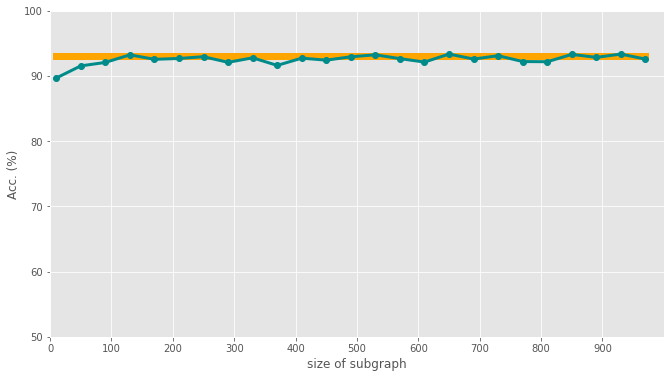

In [49]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
plt.figure(figsize=(11,6))
plt.axis([0, 1000, 50, 100])
plt.xticks(np.arange(0,1000,100))
horiz_line_data = np.array([acc for i in range(len(js))])
plt.plot(js,horiz_line_data,color='orange',linewidth=7.0)
plt.plot(js,all_accuracy,'-o',color='darkcyan',linewidth=3.0)
plt.xlabel('size of subgraph')
plt.ylabel('Acc. (%)')
plt.savefig('pic3.jpg')